In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import extend_df
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import train_test_split
from src.utils import predict_and_plot

In [424]:
raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/train.csv", index_col=0)

assert 'Surname' in raw_df.columns, "Surname column not found in dataset."
raw_df.drop(columns=['Surname'], inplace=True)
# raw_df['Surname'] = raw_df['Surname'].apply(lambda x: x[1])

intersections = [
    ('Age', 'Balance'),
    ('Age', 'NumOfProducts'),
    ('Age', 'EstimatedSalary'),
    ('Age', 'CreditScore'),
]
logarithms = [
    'Age',
    'Balance',
    'EstimatedSalary',
    'AgeCreditScoreInteraction',
    'AgeNumOfProductsInteraction',
]
squares = [
    'Age',
    'AgeBalanceInteraction'
]
raw_df = extend_df(raw_df, intersections, logarithms, squares)

In [425]:
# Identify numerical and categorical columns
numeric_cols = raw_df.select_dtypes('number').columns.tolist()
categorical_cols = raw_df.select_dtypes(['object', 'category']).columns.tolist()

In [426]:
encoder = (OrdinalEncoder()).fit(raw_df[categorical_cols])
encoded_cols = encoder.get_feature_names_out()
raw_df[encoded_cols] = encoder.transform(raw_df[categorical_cols])
# raw_df.drop(columns=categorical_cols, inplace=True)

In [427]:
# Create train and validation data sets
input_cols = raw_df.drop(columns=['CustomerId', 'Exited']).columns
target_col = raw_df[['Exited']].columns[0]

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df[target_col])

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

Area under ROC score on Training Poly dataset: 93.23%


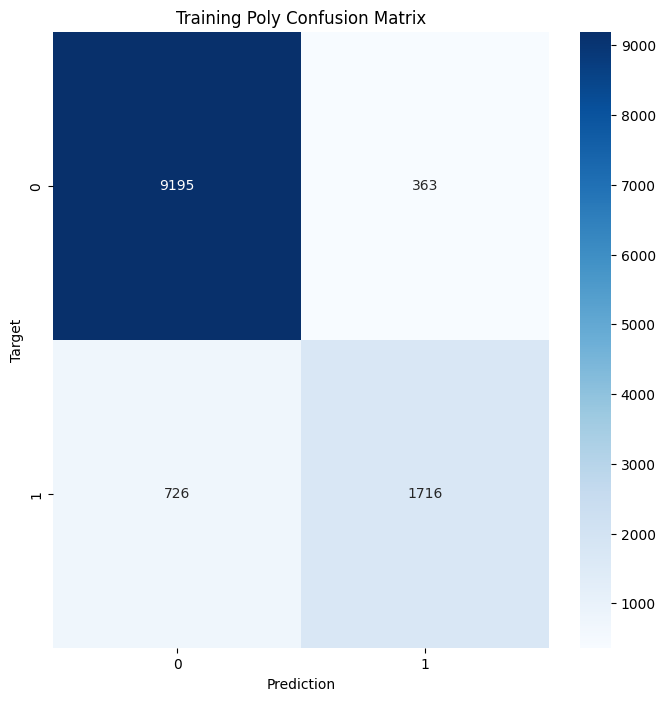

Area under ROC score on Validation Poly dataset: 91.69%


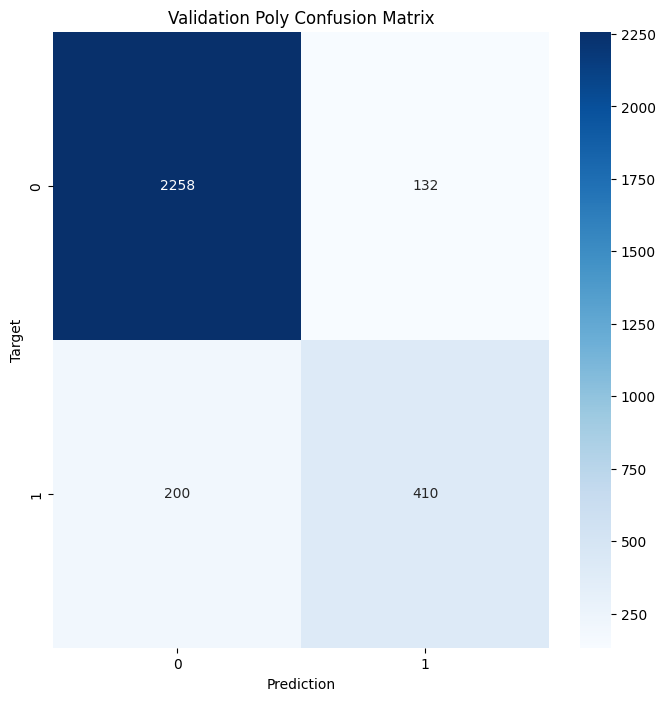

In [428]:
model = DecisionTreeClassifier(random_state=42, max_depth=9, max_leaf_nodes=65)
model.fit(train_inputs, train_targets)

train_preds = predict_and_plot(model, train_inputs, train_targets, "Training Poly")
val_preds = predict_and_plot(model, val_inputs, val_targets, "Validation Poly")


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

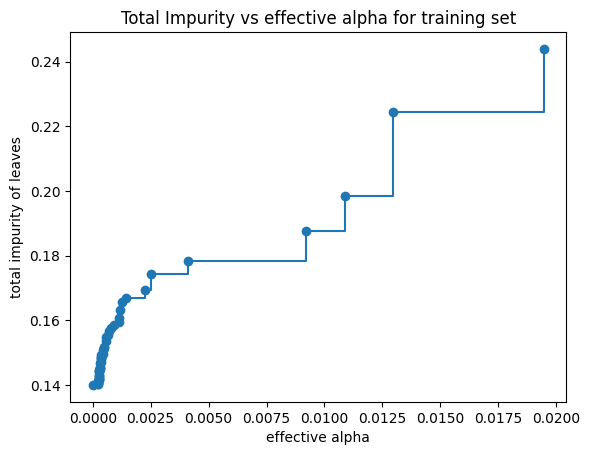

In [429]:
path = model.cost_complexity_pruning_path(train_inputs, train_targets)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [430]:
models = []
for ccp_alpha in ccp_alphas[-10:]:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(train_inputs, train_targets)
    models.append(model)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        models[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.08021653632155298


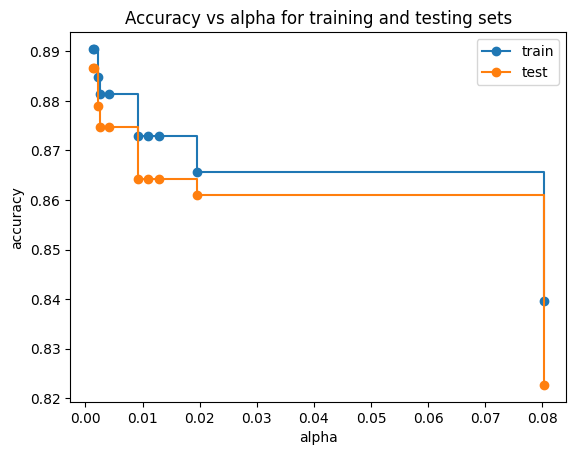

In [431]:
train_scores = [model.score(train_inputs, train_targets) for model in models]
val_scores = [model.score(val_inputs, val_targets) for model in models]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[-10:], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[-10:], val_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [432]:
def max_depth_error(md):
    model = DecisionTreeClassifier(random_state=42, max_depth=md)
    model.fit(train_inputs, train_targets)
    train_error = 1 - model.score(train_inputs, train_targets)
    val_error = 1 - model.score(val_inputs, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': val_error} 

errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])
errors_df.style.background_gradient(subset='Validation Error', cmap='Blues_r')

,Max Depth,Training Error,Validation Error
0,1,0.160417,0.177333
1,2,0.134250,0.139000
2,3,0.118500,0.125333
3,4,0.112750,0.118000
4,5,0.105750,0.111667
5,6,0.098750,0.108667
6,7,0.094167,0.109667
7,8,0.084417,0.113000
8,9,0.073750,0.117667
9,10,0.063083,0.122000


In [433]:
# model = DecisionTreeClassifier(class_weight='balanced', random_state=42, ccp_alpha=ccp_alphas[-20])
# model.fit(train_inputs, train_targets)

# model.feature_names_in_, model.feature_importances_

In [434]:
# train_preds = predict_and_plot(model, train_inputs, train_targets, "Training Poly")
# val_preds = predict_and_plot(model, val_inputs, val_targets, "Validation Poly")

In [435]:
model.tree_.max_depth

1

Area under ROC score on Training Poly dataset: 74.47%


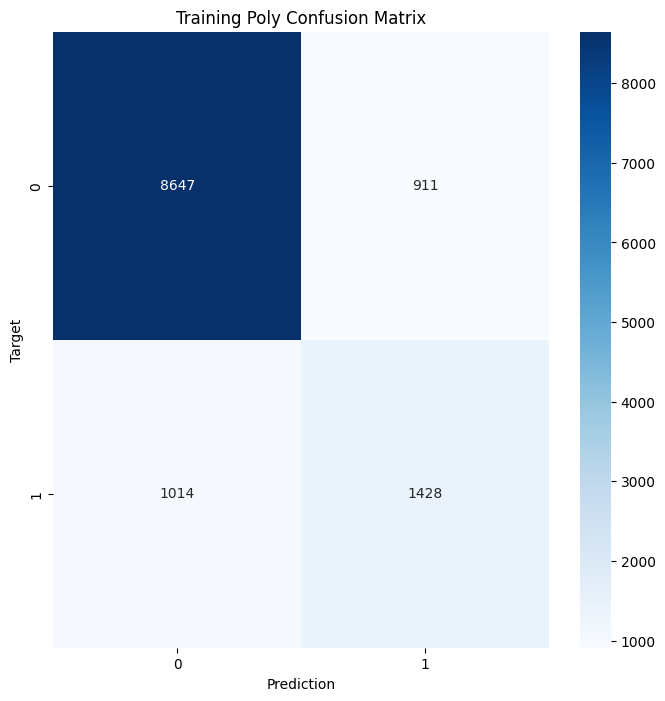

Area under ROC score on Validation Poly dataset: 73.49%


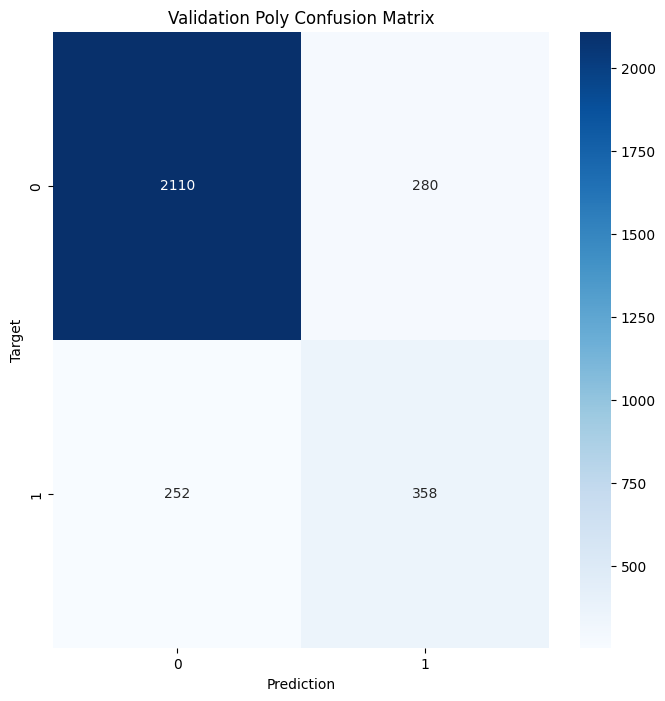

In [436]:
import xgboost as xgb
import lightgbm as lgb

xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=8, random_state=42)
xgb_model.fit(train_inputs, train_targets)

train_preds_3 = predict_and_plot(model, train_inputs, train_targets, "Training Poly")
val_preds_3 = predict_and_plot(model, val_inputs, val_targets, "Validation Poly")

In [437]:
from sklearn.metrics import accuracy_score

# 2. LightGBM Model
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lgb_model.fit(train_inputs, train_targets)
lgb_pred = lgb_model.predict(val_inputs)
lgb_accuracy = accuracy_score(val_targets, lgb_pred)
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [438]:
from src.utils import gen_submission_sample

# test_raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/test.csv")
# test_raw_df = extend_df(test_raw_df, intersections, logarithms, squares)
# gen_submission_sample(model_pipeline, test_raw_df)